# Exploratory Data Analysis of Ames Housing Prices Dataset

<a id="sec_toc"></a>
# Table of Contents
* [Dataset Details](#sec_data_details)
* [Notebook Setup](#sec_setup)
* [Summarize Data Features](#sec_sum_features)
* [Data Cleaning](#sec_clean)
* [Feature Engineering](#sec_engineering)
* [Initial Visualization](#sec_visualize)
* [Feature Selection](#sec_selection)
* [Feature Transformation](#sec_transformation)
* [Model Building](#sec_model)
* [Post-mortem](#sec_post)
* [Appendix](#sec_appendix)

_NOTE_: The organization of this notebook is non-linear. By this I mean that the justification for each step will not be made clear as one reads from top to bottom. It is organized so that the notebook runs smoothly and quickly. For example, if I get to the end and realize a way to improve my model, I go back to previous steps, make changes, and re-run the notebook. Some justifications are preserved in the appendix and I intend to add to it at the end.

<a id="sec_data_details"></a>
# Dataset Details
[top](#sec_toc)

This data set describes "the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values" ([De Cock 2011](http://jse.amstat.org/v19n3/decock.pdf))

### Feature Breakdown
* **SalePrice** - the property's sale price in dollars. This is the target variable that you're trying to predict.
* **Overall classification**
    * MSSubClass: The building class
    * MSZoning: The general zoning classification
* **Land/Lot**
    * LotFrontage: Linear feet of street connected to property
    * LotArea: Lot size in square feet
    * LotShape: General shape of property
    * LandContour: Flatness of the property
    * LotConfig: Lot configuration
    * LandSlope: Slope of property
    * Foundation: Type of foundation
* **Surroundings**
    * Street: Type of road access
    * Alley: Type of alley access
    * Neighborhood: Physical locations within Ames city limits
    * Condition1: Proximity to main road or railroad
    * Condition2: Proximity to main road or railroad (if a second is present)
* **Building classification**
    * BldgType: Type of dwelling
    * HouseStyle: Style of dwelling
    * OverallQual: Overall material and finish quality
    * OverallCond: Overall condition rating
    * YearBuilt: Original construction date
    * YearRemodAdd: Remodel date
    * Functional: Home functionality rating
* **Exterior**
    * General
        * Exterior1st: Exterior covering on house
        * Exterior2nd: Exterior covering on house (if more than one material)
        * MasVnrType: Masonry veneer type
        * MasVnrArea: Masonry veneer area in square feet
        * ExterQual: Exterior material quality
        * ExterCond: Present condition of the material on the exterior
    * Roof
        * RoofStyle: Type of roof
        * RoofMatl: Roof material
    * Deck/Porch
        * WoodDeckSF: Wood deck area in square feet
        * OpenPorchSF: Open porch area in square feet
        * EnclosedPorch: Enclosed porch area in square feet
        * 3SsnPorch: Three season porch area in square feet
        * ScreenPorch: Screen porch area in square feet
    * Pool
        * PoolArea: Pool area in square feet
        * PoolQC: Pool quality
    * Fence: Fence quality
* **Basement**
    * BsmtQual: Height of the basement
    * BsmtCond: General condition of the basement
    * BsmtExposure: Walkout or garden level basement walls
    * BsmtFinType1: Quality of basement finished area
    * BsmtFinSF1: Type 1 finished square feet
    * BsmtFinType2: Quality of second finished area (if present)
    * BsmtFinSF2: Type 2 finished square feet
    * BsmtUnfSF: Unfinished square feet of basement area
    * TotalBsmtSF: Total square feet of basement area
    * BsmtFullBath: Basement full bathrooms
    * BsmtHalfBath: Basement half bathrooms
* **Above grade (i.e. ground) interior**
    * 1stFlrSF: First Floor square feet
    * 2ndFlrSF: Second floor square feet
    * LowQualFinSF: Low quality finished square feet (all floors)
    * GrLivArea: Above grade (ground) living area square feet
    * FullBath: Full bathrooms above grade
    * HalfBath: Half baths above grade
    * Bedroom: Number of bedrooms above basement level
    * Kitchen: Number of kitchens
    * KitchenQual: Kitchen quality
    * TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
    * Fireplaces: Number of fireplaces
    * FireplaceQu: Fireplace quality
* **Garage**
    * GarageType: Garage location
    * GarageYrBlt: Year garage was built
    * GarageFinish: Interior finish of the garage
    * GarageCars: Size of garage in car capacity
    * GarageArea: Size of garage in square feet
    * GarageQual: Garage quality
    * GarageCond: Garage condition
    * PavedDrive: Paved driveway
* **Utilities**
    * Utilities: Type of utilities available
    * Heating: Type of heating
    * HeatingQC: Heating quality and condition
    * CentralAir: Central air conditioning
    * Electrical: Electrical system
* **Sale**
    * MoSold: Month Sold
    * YrSold: Year Sold
    * SaleType: Type of sale
    * SaleCondition: Condition of sale
    * MiscFeature: Miscellaneous feature not covered in other categories
    * MiscVal: Value of miscellaneous feature

For more detail on the data features, such as possible values for categorical features, see [data description](data/data_description.txt) file
 

<a id="sec_setup"></a>
# Notebook Setup
[top](#sec_toc)

In [1]:
# Imports

## Project
import utilities as util;

## 3rd-party
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    cross_val_score, train_test_split
)
from sklearn.feature_selection import (
    f_classif, mutual_info_classif,
    f_regression, mutual_info_regression,
    RFECV
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler, PowerTransformer,
    KBinsDiscretizer
)

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pingouin as pg
import statsmodels.api as sm
import pandas as pd
from scipy import stats, optimize
import numpy as np

from IPython.display import display
from tabulate import tabulate

## Built-in
from collections import defaultdict
import itertools
import os
import importlib
importlib.reload(util)

print('Directory Contents:')
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        if '/.' in dirname or '.pyc' in filename or '.swp' in filename: continue
        print('\t', os.path.join(dirname, filename))

Directory Contents:
	 ./test_utilities.ipynb
	 ./AmesHousingEDA.ipynb
	 ./AmesHousingPriceRegression.ipynb
	 ./README.md
	 ./utilities.py
	 ./sample_submission.csv
	 ./data/test.csv
	 ./data/data_description.txt
	 ./data/train.csv


In [2]:
# Load files
data_dir = './data'
df_train = pd.read_csv(f'{data_dir}/train.csv')
df_test = pd.read_csv(f'{data_dir}/test.csv')
target_var = 'SalePrice'
n = len(df_train) + len(df_test)

print(f'Train-Test split = {len(df_train)}:{len(df_test)} ({len(df_train)/n:.0%}:{len(df_test)/n:.0%})')

Train-Test split = 1460:1459 (50%:50%)


<a id="sec_sum_features"></a>
# Summarize Data Features
[top](#sec_toc)

In [3]:
target_val = 'SalePrice'

manual_type_set = {
    'Continuous' : [
       'LowQualFinSF',  # very few unique values 
       '3SsnPorch', 
       'PoolArea',
       'MiscVal',
    ],
    'Discrete' : [
        'Id',
        'BedroomAbvGr', # called 'Bedroom' in data_description.txt
        'KitchenAbvGr', # called 'Kitchen' in data_description.txt
        'Fireplaces',
        'MoSold',
        'YrSold',
        'YearBuilt',
        'GarageYrBlt',
        'YearRemodAdd',
        'GarageCars',
        'HalfBath',
        'FullBath',
        'BsmtHalfBath',
        'BsmtFullBath',
    ],
    'Ordinal' : [
        'OverallQual',
        'OverallCond',
        'ExterQual',
        'ExterCond',
        'PoolQC',
        'Fence',
        'BsmtFinType1',
        'BsmtFinType2',
        'BsmtQual',
        'BsmtCond',
        'BsmtExposure',
        'GarageQual',
        'GarageType', # maybe?
        'GarageFinish',
        'GarageCond',
        'KitchenQual',
        'FireplaceQu',
        'HeatingQC',
        'Electrical',
        'Functional',
        'PavedDrive',
    ]
    #'Nominal' : [
    #    
    #]
}
manual_type_set = {v:k  for k in manual_type_set for v in manual_type_set[k]}
data_types = util.categorize_data_type(df_train, override=manual_type_set)

In [4]:
df_features = data_types.to_frame('Data Subtype')
df_features['# Missing'] = df_train.isnull().sum()
df_features['% Missing'] = df_features['# Missing']/len(df_train)
df_features['# Unique']  = df_train.nunique()

# Quantify how balanced (i.e. evenly spread out) the data is
df_features['Entropy']      = [stats.entropy(df_train[c].value_counts()) for c in df_train]
df_features['Max Entropy']  = np.log(df_features['# Unique'])
df_features['Norm Entropy'] = df_features['Entropy']/df_features['Max Entropy']

# Variables to fill in for loop
df_features[[
             # Calculate the count ratio of the 1st and 2nd modes to identify unbalanced features
             'Mode', 'Mode Count', 'Mode %', 'Mode 2', 'Mode Ratio', 'Min Count',
             # Categorize as categorical or numerical
             'Data Type',
             # Correlations to target variable and the effect size
             'F pval', 'Mutual Info', 'R2',
             'Pearson r', 'Pearson r pval',
            ]] = np.nan

#num_cols = df_features.index[df_features['Data Subtype'].isin(['Continuous', 'Discrete'])].to_list()
for col in df_train:
    data = df_train[col]
    notnull = data.notnull()
    feature = df_features.loc[col,:].copy()
    x, y = data.loc[notnull], df_train.loc[notnull, target_var]
    x2d = pd.DataFrame(x, columns=[col])
    y2d = pd.DataFrame(y, columns=[target_var])
    
    # Mode
    vc = data.value_counts().sort_values(ascending=False)
    feature['Mode']       = vc.index[0]
    feature['Mode Count'] = vc.iloc[0]
    feature['Mode %']     = vc.iloc[0] / vc.sum()
    if len(vc) > 1:
        feature['Mode 2'] = vc.index[1]
        feature['Mode Ratio'] = vc.iloc[0]/vc.iloc[1]
    feature['Min Count'] = vc.iloc[-1] 

    # Data type specific
    dt = feature['Data Subtype']
    if dt in ['Continuous', 'Discrete']:
        feature['Data Type'] = 'Numerical'
        
        r, pval = stats.pearsonr(x, y)
        feature['Pearson r']      = r
        feature['Pearson r pval'] = pval*100
        feature['R2']             = r**2
        
        mi = mutual_info_regression(x2d, y)
        feature['Mutual Info'] = mi
        
    elif dt in ['Ordinal', 'Nominal']:
        feature['Data Type'] = 'Categorical'

        if feature['Min Count'] > 1:
            pval, n2 = pg.welch_anova(data=df_train, dv=target_var, between=col)[['p-unc', 'np2']].values[0]
            feature['F pval'] = pval * 100
            feature['R2'] = n2
        
        mi = mutual_info_classif(y2d, x)[0]
        feature['Mutual Info'] = mi
        
    else:
        feature['Data Type'] = 'Unknown'
    
    df_features.loc[col,:] = feature

# Show results
to_print = ['Data Subtype', '# Missing', '# Unique', 'Mode Ratio', 'Min Count', 'R2']
sort_by = ['Data Subtype', '# Missing', 'Norm Entropy']

with pd.option_context('display.max_rows', None, 
                       'display.max_columns', None):
    display(df_features.sort_values(by=sort_by, ascending=False)[to_print].round(2))

,Data Subtype,# Missing,# Unique,Mode Ratio,Min Count,R2
PoolQC,Ordinal,1453,3,1.50,2.0,0.58
Fence,Ordinal,1179,4,2.66,11.0,0.21
FireplaceQu,Ordinal,690,5,1.21,20.0,0.24
GarageFinish,Ordinal,81,3,1.43,352.0,0.27
GarageType,Ordinal,81,6,2.25,6.0,0.21
GarageQual,Ordinal,81,5,27.31,3.0,0.03
GarageCond,Ordinal,81,5,37.89,2.0,0.03
BsmtExposure,Ordinal,38,4,4.31,114.0,0.13
BsmtFinType2,Ordinal,38,6,23.26,14.0,0.01
BsmtFinType1,Ordinal,37,6,1.03,74.0,0.19


<a id="sec_clean"></a>
## Data Cleaning
[top](#sec_toc)

In [5]:
df_tmp = df_train.copy()

col_to_drop = []
num_cols = df_features.index[df_features['Data Type'] == 'Numerical']
cat_cols = df_features.index[df_features['Data Type'] == 'Categorical']

# Remove features with too many missing values
null_percent_cutoff = 0.40
#p_null = df_features['% Missing']
filt = df_features['% Missing'] > null_percent_cutoff
col_to_drop += df_features.loc[filt,'% Missing'].index.tolist()
print('Dropping columns based on null % >', null_percent_cutoff)
print(df_features.loc[col_to_drop,'% Missing'].sort_values(),'\n')

# Remove irrelevant features
col_to_drop.append('Id')

# Remove colinear features
# col_to_drop += ['GrLivArea', 'TotalBsmtSF']

# Handle outliers and corrupt data
df_tmp.loc[df_tmp['GarageYrBlt'] > 2010, 'GarageYrBlt'] = np.nan # All dates beyond this are bugs (e.g. 2207)

# Impute missing values
num_strategy = 'median'
cat_strategy = ['constant', 'Unknown']

n_before = df_tmp[num_cols].isnull().sum().sum()
imp_num = SimpleImputer(missing_values=np.nan, strategy=num_strategy)
imp_num.fit(df_tmp[num_cols])
df_tmp[num_cols] = imp_num.transform(df_tmp[num_cols])
n_after = df_tmp[num_cols].isnull().sum().sum()
print(f'Null values (numerical) before ({n_before}) and after ({n_after})')

n_before = df_tmp[cat_cols].isnull().sum().sum()
imp_cat = SimpleImputer(missing_values=np.nan, strategy=cat_strategy[0], fill_value=cat_strategy[1])
imp_cat.fit(df_tmp[cat_cols])
df_tmp[cat_cols] = imp_cat.transform(df_tmp[cat_cols])
n_after = df_tmp[cat_cols].isnull().sum().sum()
print(f'Null values (categorical) before ({n_before}) and after ({n_after})')

# Finalize cleaning
num_cols = num_cols.difference(col_to_drop)
cat_cols = cat_cols.difference(col_to_drop)
df_features = df_features.drop(col_to_drop)
df_clean = df_tmp.drop(columns=col_to_drop)

Dropping columns based on null % > 0.4
FireplaceQu    0.472603
Fence          0.807534
Alley          0.937671
MiscFeature    0.963014
PoolQC         0.995205
Name: % Missing, dtype: float64 

Null values (numerical) before (348) and after (0)
Null values (categorical) before (6617) and after (0)


<a id="sec_engineering"></a>
## Feature Engineering
[top](#sec_toc)

In [6]:
df_clean['TotalSF'] = df_clean['GrLivArea'] + df_clean['TotalBsmtSF']

#df_clean['Neighborhood_lon'] = 
#df_clean['Neighborhood_lat'] = 

for idx in df_clean.index:
    porch_type = []
    if df_clean.loc[idx, 'WoodDeckSF'] > 0:
        porch_type.append('Wood')
    if df_clean.loc[idx, 'OpenPorchSF'] > 0:
        porch_type.append('Open')
    if df_clean.loc[idx, 'EnclosedPorch'] > 0:
        porch_type.append('Enclosed')
    if df_clean.loc[idx, 'ScreenPorch'] > 0:
        porch_type.append('Screen')
    if df_clean.loc[idx, '3SsnPorch'] > 0:
        porch_type.append('3Ssn')
    
    df_clean.loc[idx,'nPorches'] = len(porch_type)
    
    porch_type = "_".join(porch_type) if porch_type else 'No Porch'
    df_clean.loc[idx,'PorchType'] = porch_type

# var = 'nPorches'
# display(df_clean[var].value_counts().sort_index())
# sns.countplot(data=df_clean, y=var, orient='h')
# plt.show()

# df_grp = df_clean.groupby(var)[target_var]
# sorted_index = df_grp.median().sort_values().index
# sns.boxplot(data=df_clean, y=var, x=target_var, 
#         orient='h', whis=np.inf, order=sorted_index)
# sns.stripplot(data=df_clean, y=var, x=target_var, 
#           orient='h', order=sorted_index,
#           jitter=True, size=3, color=".3", linewidth=0)
# plt.show()

# df_clean = df_clean.drop(columns=var)

# Combine
# GarageCars -> 0, 1, 2, 3+

num_cols = num_cols.union(pd.Index(['TotalSF', 'nPorches']))
cat_cols = cat_cols.union(pd.Index(['PorchType']))

<a id="sec_visualize"></a>
## Initial Visualization
[top](#sec_toc)

In [7]:
import statsmodels.stats.stattools as sm_stattools 
import statsmodels.stats.diagnostic as sm_diagnostic
import statsmodels.stats.api as sm_stats

def num_num_corr_plots(df, feature1, feature2, trim=5, x_jitter=0):
    filt = df[feature1].notnull()
    x, y = df.loc[filt,feature1], df.loc[filt, feature2]
    x2d = pd.DataFrame(x)
    
    model = sm.OLS(y, sm.add_constant(x2d))
    result = model.fit()
    residual = y.values - result.predict(sm.add_constant(x2d))
    
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    
    ########################################
    # Visualize relationship with scatter plot (check for linearity)
    ax = axs[0,0]
    # Scatter plot
    x_jitter = x + stats.uniform.rvs(size=len(x), loc=-x_jitter, scale=2*x_jitter)
    ax.scatter(x_jitter, y, label='Data')
    x_ref = np.linspace(min(x), max(x), 100)
    y_pred = result.predict(sm.add_constant(x_ref.reshape(-1,1)))
    
    # Linear fit
    ax.plot(x_ref, y_pred, 'k', lw=3, label='Linear Fit')
    
    # Siegel Linear fit
    m, b = stats.siegelslopes(y, x)
    y_pred = m * x_ref + b
    ax.plot(x_ref, y_pred, 'g--', lw=2, label='Siegel Fit')
    
    # LOWESS fit
    frac = 1/3
    with np.errstate(invalid='ignore'):
        # Avoid smoothers_lowess.py: invalid value encountered in true_divide
        # Occurs with discrete data because of relatively large gaps
        lowess = sm.nonparametric.lowess(y, x, frac=frac)
    ax.plot(lowess[:,0], lowess[:,1], 'c--', lw=2, label='LOWESS Fit')
    
#     # kNN fit
#     n_neighbors = 5
#     knn = KNeighborsRegressor(n_neighbors, p=2)
#     #normalize_x = StandardScaler().fit(x2d)
#     #normalize_y = StandardScaler().fit(y.to_frame())
#     #x_norm      = normalize_x.transform(x2d)
#     #x_ref_norm  = normalize_x.transform(x_ref.reshape(-1,1))
#     #y_norm      = normalize_y.transform(y.to_frame())
#     #y_knn_norm = knn.fit(x_norm, y_norm).predict(x_ref_norm.reshape(-1,1))
#     #y_knn = normalize_y.inverse_transform(y_knn_norm)
#     y_knn = knn.fit(x2d, y).predict(x_ref.reshape(-1,1))
#     ax.plot(x_ref, y_knn, 'r--', lw=2, label='kNN Fit')
    
    ## Local mean
    #x_local, y_mean, _, _ = util.local_sigma_bands(x, y,  window_scale=5, percentiles=True)
    #ax.plot(x_local, y_mean, 'r--', lw=3, label='Local $\mu$')
    
    # (TODO) Check for non-linearity
    
    # Finalize plot
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.legend()
    xlo, xhi = ax.get_xlim()
    diff = xhi-xlo
    xlo, xhi = xlo - 0.05*diff, xhi + 0.05*diff
    ax.set_xlim(xlo, xhi)
    
    ########################################
    # Visualize residuals to check linearity and homoskedasticity
    ax = axs[1,0]
    p_data = ax.scatter(x_jitter, residual, label='Residuals')
    ax.axhline(0, ls=':', c='k')
    #x_ref, ymid, ylo, yhi = util.local_sigma_bands(x, residual, window_scale=10, percentiles=True)
    x_ref, ymid, ylo, yhi = util.local_sigma_bands(x, residual, window_scale=1/3)
    p_mean, = ax.plot(x_ref, ymid, 'k--', alpha=0.7)
    p_sigma = ax.fill_between(x_ref, yhi, ylo, color='k', alpha=0.3)
    ax.set_xlabel(feature1)
    ax.set_ylabel(f'{feature2} Residual')
    ax.set_xlim(xlo, xhi)
    ax.legend([p_data, (p_mean,p_sigma)], ['Data', 'Local $\mu\pm\sigma$'])
    
    ########################################
    # Visualize residuals to check normality
    ax = axs[0,1]
    sns.histplot(residual, kde=True, stat='density', label='Data w/ KDE', ax=ax)
    mean, std = np.mean(residual), np.std(residual)
    lo, hi = np.percentile(residual, [trim/2,100-trim/2])
    diff = hi - lo
    xmin, xmax = lo - diff/2, hi + diff/2
    mean_trim, std_trim = stats.tmean(residual, (lo, hi)), stats.tstd(residual, (lo, hi))
    x_ref = np.linspace(xmin, xmax, 1000)
    norm_ref = stats.norm(loc=mean, scale=std).pdf(x_ref)
    norm_ref_trim = stats.norm(loc=mean_trim, scale=std_trim).pdf(x_ref)
    ax.plot(x_ref, norm_ref, 'r', label='Normal Fit')
    ax.plot(x_ref, norm_ref_trim, 'r--', label='Trimmed Normal Fit')
    ax.axvline(lo, c='k', ls=':', label='Trim Edges')
    ax.axvline(hi, c='k', ls=':')
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Residual')
    ax.legend()
    
    # Visualize residuals to check normality
    ax = axs[1,1]
    sm.qqplot(residual, line='s', ax=ax, markerfacecolor='b')
    lo, hi = np.percentile(residual, [trim/2,100-trim/2])
    h_trim = ax.axhline(lo, c='k', ls=':')
    ax.axhline(hi, c='k', ls=':')
    _, pval = stats.normaltest(residual)
    ax.annotate(f'Normal Test : p-val = {pval:.2%}', size='x-large',
                      xy=(0.5,0.9), xycoords='axes fraction', ha='center')
    res_trim = residual[(lo <= residual) & (residual <= hi)]
    _, pval = stats.normaltest(res_trim)
    ax.annotate(f'(Trim {trim}% : p-val = {pval:.2%})', size='large',
                      xy=(0.5,0.8), xycoords='axes fraction', ha='center')
    ymin, ymax = ax.get_ylim()
    height = ymax - ymin
    ax.set_ylim(ymin, ymax+height/5)
    h_data = Line2D([0],[0], color='b', lw=0, marker='o')
    h_normal = Line2D([0],[0], color='r')
    ax.legend([h_data, h_normal, h_trim], ['Data', 'Normal Ref', 'Trim Edges'], loc='lower right')

     ## Determine dependency of normality pval on outliers
     #pvals = []
     #percentiles = np.linspace(0,20,100)
     #for p in percentiles:
     #    lo, hi = np.percentile(residual, [p/2, 100-p/2])
     #    res_trim = residual[(lo <= residual) & (residual <= hi)]
     #    _, pval = stats.normaltest(res_trim)
     #    pvals.append(pval)
     #ax.plot(percentiles, pvals, 'bo')
     #ax.set_xlabel('Edge Percentile Trim')
     #ax.set_ylabel('p-value')
     #print(percentiles[np.argmax(pvals)])
    
    ########################################
    # (TODO) Visualize residuals to check outliers 
    #  - z-score, leverage, DFFITS, Studentized residuals, Cook's D

    ########################################
    # (TODO) Visualize residuals to check autocorrelation

    plt.show()
    ########################################
    # Quantify correlation, significance, and residual behavior
    print('Correlation Measures:')
    m, m_unc, m_pval = result.params[1], result.bse[1], result.pvalues[1]
    pr, pr_pval = stats.pearsonr(x, y)
    sr, sr_pval = stats.spearmanr(x, y)
    #pr, pr_pval, r2, bf10 = pg.corr(x, y, method='pearson')[['r','p-val','r2','BF10']].values[0]
    mi = mutual_info_regression(x.to_frame(), y)[0]
    print(f"\t         Fit Slope = {m:.2f} +/- {m_unc:.2f} (pval = {m_pval:.1%})")
    print(f"\t       Pearson's r = {pr:.2f} (pval = {pr_pval:.1%}; R2 = {pr**2:.2f})")
    print(f"\t      Spearman's r = {sr:.2f} (pval = {sr_pval:.1%})")
    print(f"\tMutual information = {mi:.3f}")
    
    print("\nHomoscedasticity Tests on Residuals: ")
    br_pval = sm_diagnostic.het_breuschpagan(residual, x.to_frame())[3]
    print(f"\t Breusch-Pagan p-value = {br_pval:.1%}")
    
    print("\nNormality Tests on Residuals : ")
    #print(f"\t      Shapiro-Wilk p-value = {stats.shapiro(residual)[1]:.1%}")
    #print(f"\t       Jarque-Bera p-value = {stats.jarque_bera(residual)[1]:.1%}")
    print(f"\tD'Agostino-Pearson p-value = {stats.normaltest(residual)[1]:.1%}")
    print(f"\t   Normal Kurtosis p-value = {stats.kurtosistest(residual)[1]:.1%}")
    print(f"\t       Normal Skew p-value = {stats.skewtest(residual)[1]:.1%}")
    
#     print("\nLinearity Tests : ") # Always giving large pvalues (?)
#     rb_pval = sm_stats.linear_rainbow(result, frac=0.5)[1]
#     hc_pval = sm_diagnostic.linear_harvey_collier(result)[1]
#     print(f"\t       Rainbow = {rb_pval:.1%}")
#     print(f"\tHarvey Collier = {hc_pval:.1%}")
    
    print("\nAutocorrelation Tests on Residuals : ")
    print(f"\tDurbin-Watson = {sm_stattools.durbin_watson(residual):.1f}")

    #print("Outlier Tests : ")

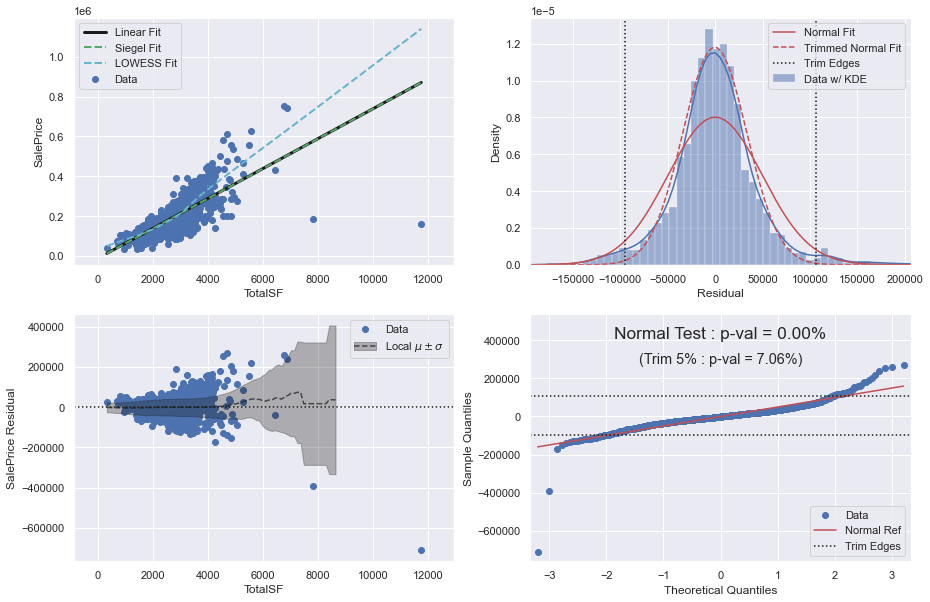

Correlation Measures:
	         Fit Slope = 75.14 +/- 1.58 (pval = 0.0%)
	       Pearson's r = 0.78 (pval = 0.0%; R2 = 0.61)
	      Spearman's r = 0.81 (pval = 0.0%)
	Mutual information = 0.663

Homoscedasticity Tests on Residuals: 
	 Breusch-Pagan p-value = 0.0%

Normality Tests on Residuals : 
	D'Agostino-Pearson p-value = 0.0%
	   Normal Kurtosis p-value = 0.0%
	       Normal Skew p-value = 0.0%

Autocorrelation Tests on Residuals : 
	Durbin-Watson = 2.0


In [8]:
num_num_corr_plots(df_clean, 'TotalSF', target_var)
#num_num_corr_plots(df_clean, 'OverallQual', target_var, x_jitter=.2)
#num_num_corr_plots(df_clean, 'KitchenAbvGr', target_var, x_jitter=.3)

In [9]:
def cat_num_corr_plots(df, cat_feature, num_feature):
    df_grp = df.groupby(cat_feature)[num_feature]
    sorted_index = df_grp.mean().sort_values().index
    
    std_rmse = lambda x : np.sqrt(np.mean(((x - x.mean())/x.std())**2))
    #rmse = lambda x : np.sqrt(np.mean((x - x.mean())**2))
    std_mae = lambda x : np.mean(np.abs((x - x.mean())/x.std()))
    shapiro = lambda x : np.round(stats.shapiro(x)[1],3) if len(x) > 2 else np.nan
    jarque = lambda x : np.round(stats.jarque_bera(x)[1],3) if len(x) > 2 else np.nan
    dagostino = lambda x : np.round(stats.normaltest(x)[1],3) if len(x) >= 20 else np.nan
    skew = lambda x : np.round(stats.skewtest(x)[1],3) if len(x) > 8 else np.nan
    kurtosis = lambda x : np.round(stats.kurtosistest(x)[1],3) if len(x) >= 20 else np.nan
    p_outliers = lambda x : pg.madmedianrule(x).sum()/len(x)
    agg_funcs = ['count', 'mean', 'median', 'std', 
                 skew, kurtosis, jarque, dagostino, shapiro, p_outliers]
    df_tests = df_grp.agg(agg_funcs).rename(
    columns={
             '<lambda_0>':'Normal Skew pval',
             '<lambda_1>':'Normal Kurtosis pval',
             '<lambda_2>':'Normality (D\'Agostino) pval',
             '<lambda_3>':'Normality (Jarque) pval',
             '<lambda_4>':'Normality (Shapiro) pval',
             '<lambda_5>':'% MAD-median outliers', 
            },
    )

    fig, axs = plt.subplots(1,3,figsize=(15,5))
    ax = axs[0]
    sns.countplot(data=df, y=cat_feature, order=sorted_index, ax=ax)

    # Raw visualization
    ax = axs[1]
    sns.boxplot(data=df, y=cat_feature, x=num_feature, 
            orient='h', whis=np.inf, order=sorted_index, 
            ax=ax)
    sns.stripplot(data=df, y=cat_feature, x=num_feature, 
              orient='h', order=sorted_index,
              jitter=True, size=3, color=".3", linewidth=0,
              ax=ax)

    # Standardized residual plot
    ax = axs[2]
    resids = pd.DataFrame(df[cat_feature], columns=[cat_feature])
    resids['Residual'] = df[num_feature] - df_grp.transform('mean')
    resids['Standardized Residual'] = resids['Residual']/df_grp.transform('std')
    resids.sample(15)
    #f = lambda x : (x[num_feature] - df_tests[x[cat_feature]]['mean'])/df_tests[x[cat_feature]]['std']
    #resids['Standardized Residual'] = df.apply(f, axis=0)
    sns.boxplot(data=resids, y=cat_feature, x='Standardized Residual', 
            orient='h', whis=1.5, order=sorted_index,
            ax=ax)
#     sns.stripplot(data=resids, y=cat_feature, x='Standardized Residual', 
#               orient='h', order=sorted_index,
#               jitter=True, size=3, color=".3", linewidth=0,
#               ax=ax)

    # Polynomial fit to enumerated categories
#     ax = axs[1,0]
#     if fit_agg:
#         x = df_tests.index
#         y = fit_agg
#         data = df_tests
#     else:
#         x = cat_feature
#         y = num_feature
#         data = df
#     sns.lineplot(x=x, y=y, data=data, 
#             #order=order, ci = None,
#             #x_jitter=0.2,
#             #line_kws=dict(color='k'),
#             ax=ax)
#     ax.set_ylabel(f'{fit_agg} {num_feature}')

    plt.show()
    a_res = pg.anova(data=df, dv=num_feature, between=cat_feature)
    w_res = pg.welch_anova(data=df, dv=num_feature, between=cat_feature)
    k_res = pg.kruskal(data=df, dv=num_feature, between=cat_feature)

    print("Effect Size")
    print(f"\tClassic ANOVA : eta^2 = {a_res.loc[0,'np2']:.2f}")
    print(f"\t  Welch ANOVA : eta^2 = {w_res.loc[0,'np2']:.2f}")
    
    print("Tests for no correlation")
    F, pval = a_res[['F', 'p-unc']].values[0]
    print(f'\tClassic ANOVA : F={F:.3f} (pval = {pval:.1%})')
    F, pval = w_res[['F', 'p-unc']].values[0]
    print(f'\tWelch   ANOVA : F={F:.3f} (pval = {pval:.1%})')
    F, pval = k_res[['H', 'p-unc']].values[0]
    print(f'\tKruskal ANOVA : H={F:.3f} (pval = {pval:.1%})')

    print("Tests for homoskedasticity")
    W, pval,_ = pg.homoscedasticity(df, dv=num_feature, group=cat_feature, method='bartlett').values[0]
    print(f"\tBartlett's test       : {W:.3f} (pval = {pval:.1%})")
    W, pval,_ = pg.homoscedasticity(df, dv=num_feature, group=cat_feature).values[0]
    print(f"\tLevene's test         : {W:.3f} (pval = {pval:.1%})")
    _, ddof, H, pval = pg.kruskal(df, dv=num_feature, between=cat_feature).values[0]
    print(f"\tKruskal-Wallis H-test : {H:.3f} (pval = {pval:.1%}; ddof = {ddof:d})")
    
    print("Pairwise comparisons and potential groupings")
    
    display(df_tests.loc[sorted_index,:].round(3))

In [10]:
var = 'RoofMatl'
df = df_clean[[var, target_var]].groupby(var).filter(lambda x : len(x) > 2)

res_tt = pg.pairwise_ttests(data=df, dv=target_var, between=var)
res_tt = res_tt.rename(columns={'p-unc':'pval'})

res_mw = pg.pairwise_ttests(data=df, dv=target_var, between=var, parametric=False)
res_mw = res_mw.rename(columns={'U-val': 'U', 'p-unc':'p-mwu'})

res_tu = pg.pairwise_tukey(data=df, dv=target_var, between=var)
res_tu = res_tu.rename(columns={'T': 'T-tukey'})

res_gh = pg.pairwise_gameshowell(data=df, dv=target_var, between=var)
res_gh = res_gh.rename(columns={'T': 'T-games', 'pval' : 'p-games'})

res = pd.concat([
    res_tt[['A', 'B', 'T', 'pval']],
    res_tu[['T-tukey', 'p-tukey']],
    res_gh[['T-games', 'p-games']],
    res_mw[['p-mwu']]
    ], axis=1
)
display(res.sort_values('pval', ascending=False).round(3))

,A,B,T,pval,T-tukey,p-tukey,T-games,p-games,p-mwu
0,CompShg,Tar&Grv,-0.282,0.783,-0.236,0.900,-0.282,0.900,0.574
5,WdShake,WdShngl,-1.730,0.140,-3.137,0.009,-1.730,0.395,0.171
4,Tar&Grv,WdShngl,-2.361,0.060,-5.150,0.001,-2.361,0.193,0.006
2,CompShg,WdShngl,-2.490,0.055,-6.564,0.001,-2.490,0.176,0.001
3,Tar&Grv,WdShake,-2.194,0.047,-1.325,0.542,-2.194,0.176,0.126
1,CompShg,WdShake,-3.773,0.018,-1.754,0.296,-3.773,0.061,0.014


/Users/alexarmstrong/anaconda3/envs/LexBase/lib/python3.8/site-packages/pingouin/nonparametric.py:145: RuntimeWarning: divide by zero encountered in true_divide
  return (np.fabs(a - np.median(a)) / mad(a)) > k
/Users/alexarmstrong/anaconda3/envs/LexBase/lib/python3.8/site-packages/pingouin/nonparametric.py:145: RuntimeWarning: invalid value encountered in true_divide
  return (np.fabs(a - np.median(a)) / mad(a)) > k


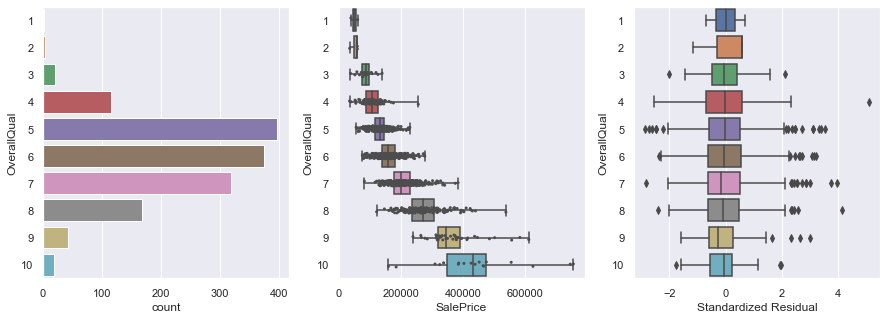

Effect Size
	Classic ANOVA : eta^2 = 0.68
	  Welch ANOVA : eta^2 = 0.68
Tests for no correlation
	Classic ANOVA : F=349.027 (pval = 0.0%)
	Welch   ANOVA : F=204.460 (pval = 0.0%)
	Kruskal ANOVA : H=966.103 (pval = 0.0%)
Tests for homoskedasticity
	Bartlett's test       : 452.423 (pval = 0.0%)
	Levene's test         : 33.093 (pval = 0.0%)
	Kruskal-Wallis H-test : 966.103 (pval = 0.0%; ddof = 9)
Pairwise comparisons and potential groupings


,count,mean,median,std,Normal Skew pval,Normal Kurtosis pval,Normality (D'Agostino) pval,Normality (Jarque) pval,Normality (Shapiro) pval,% MAD-median outliers
OverallQual,,,,,,,,,,
1,2,50150.000,50150.0,15344.217,NaN,NaN,NaN,NaN,NaN,0.000
2,3,51770.333,60000.0,14254.201,NaN,NaN,0.767,NaN,-0.000,0.333
3,20,87473.750,86250.0,24688.567,0.729,0.611,0.958,0.828,0.985,0.150
4,116,108420.655,108000.0,29022.004,0.000,0.000,0.000,0.000,0.000,0.034
5,397,133523.348,133000.0,27107.331,0.007,0.001,0.000,0.000,0.000,0.096
6,374,161603.035,160000.0,36090.183,0.005,0.116,0.005,0.006,0.003,0.075
7,319,207716.423,200141.0,44466.259,0.000,0.001,0.000,0.000,0.000,0.060
8,168,274735.536,269750.0,63898.902,0.000,0.008,0.000,0.000,0.000,0.083
9,43,367513.023,345000.0,81278.175,0.001,0.037,0.000,0.000,0.000,0.116


In [11]:
cat_num_corr_plots(df_clean, 'OverallQual', target_var)
#cat_num_corr_plots(df_clean, 'Neighborhood', target_var) 
#cat_num_corr_plots(df_clean, 'RoofMatl', target_var) 

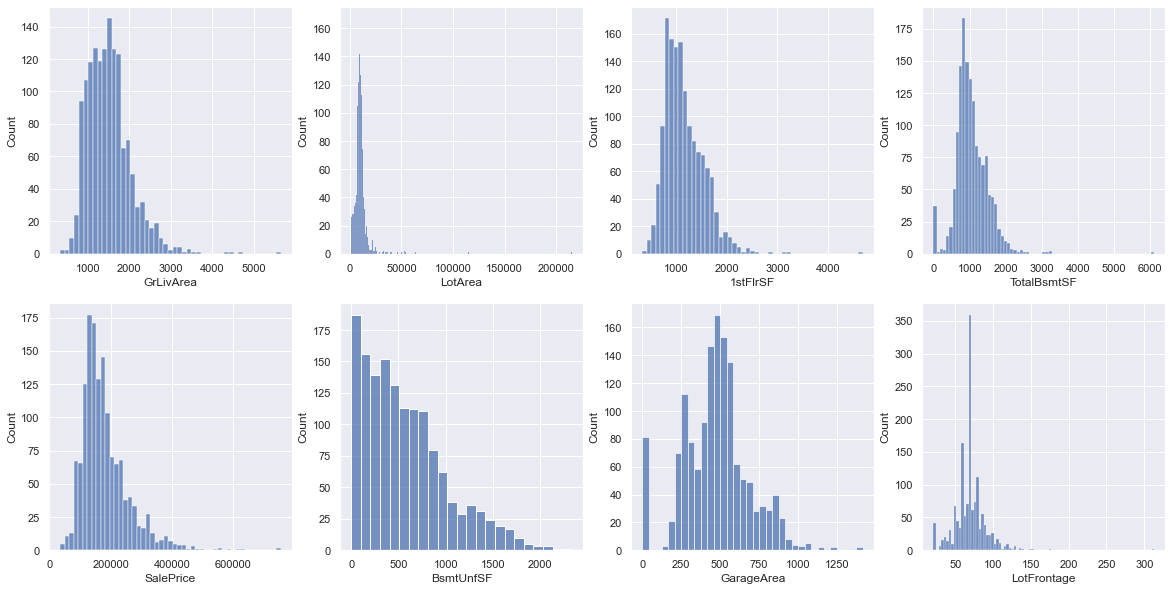

In [12]:
filt = (df_features["Data Subtype"] == 'Continuous') & (df_features["Mode Ratio"] <= 15)
cols = df_features.loc[filt,:].sort_values('Norm Entropy', ascending=False).index
fig, axs = util.plot_grid(df_clean, cols, plottype = 'histplot')

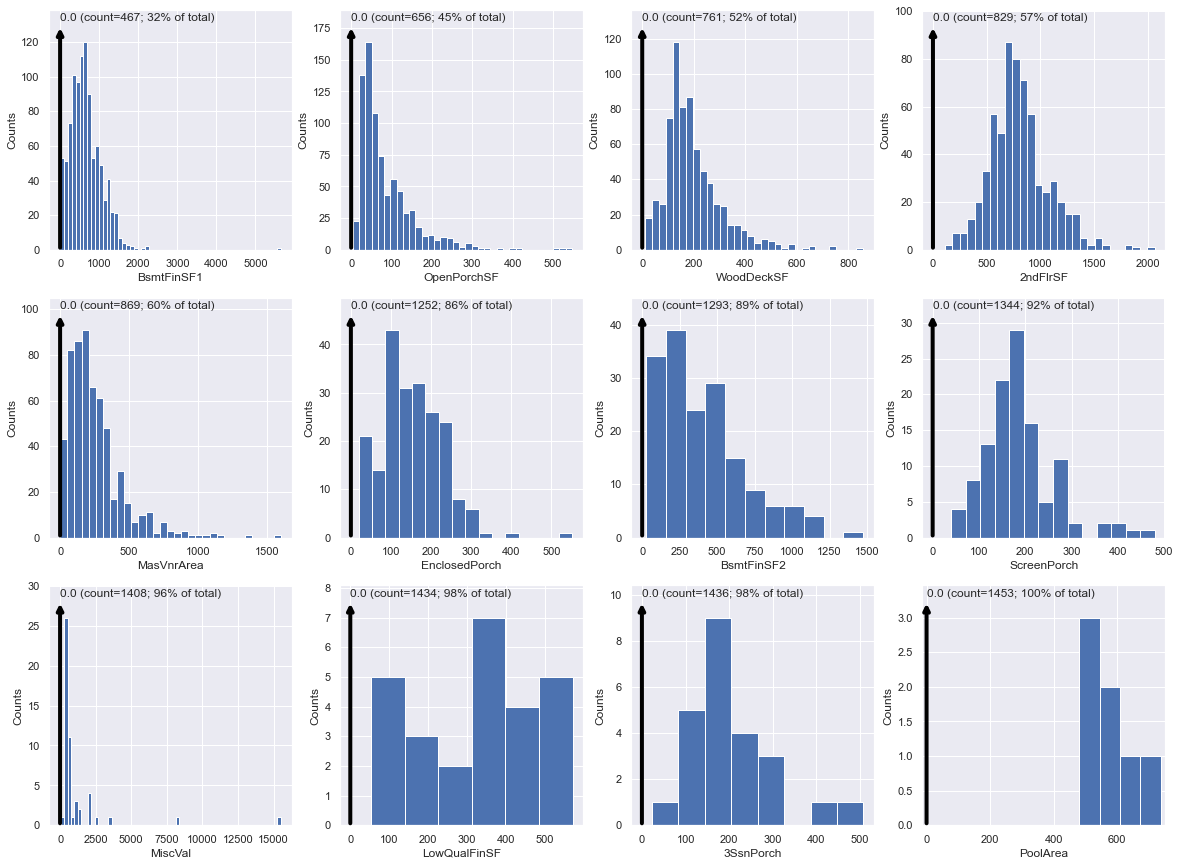

In [13]:
filt = (df_features["Data Subtype"] == 'Continuous') & (df_features["Mode Ratio"] > 15)
cols = df_features.loc[filt,:].sort_values('Norm Entropy', ascending=False).index
fig, axs = util.plot_grid(df_clean, cols, plottype = 'histplot_crop')

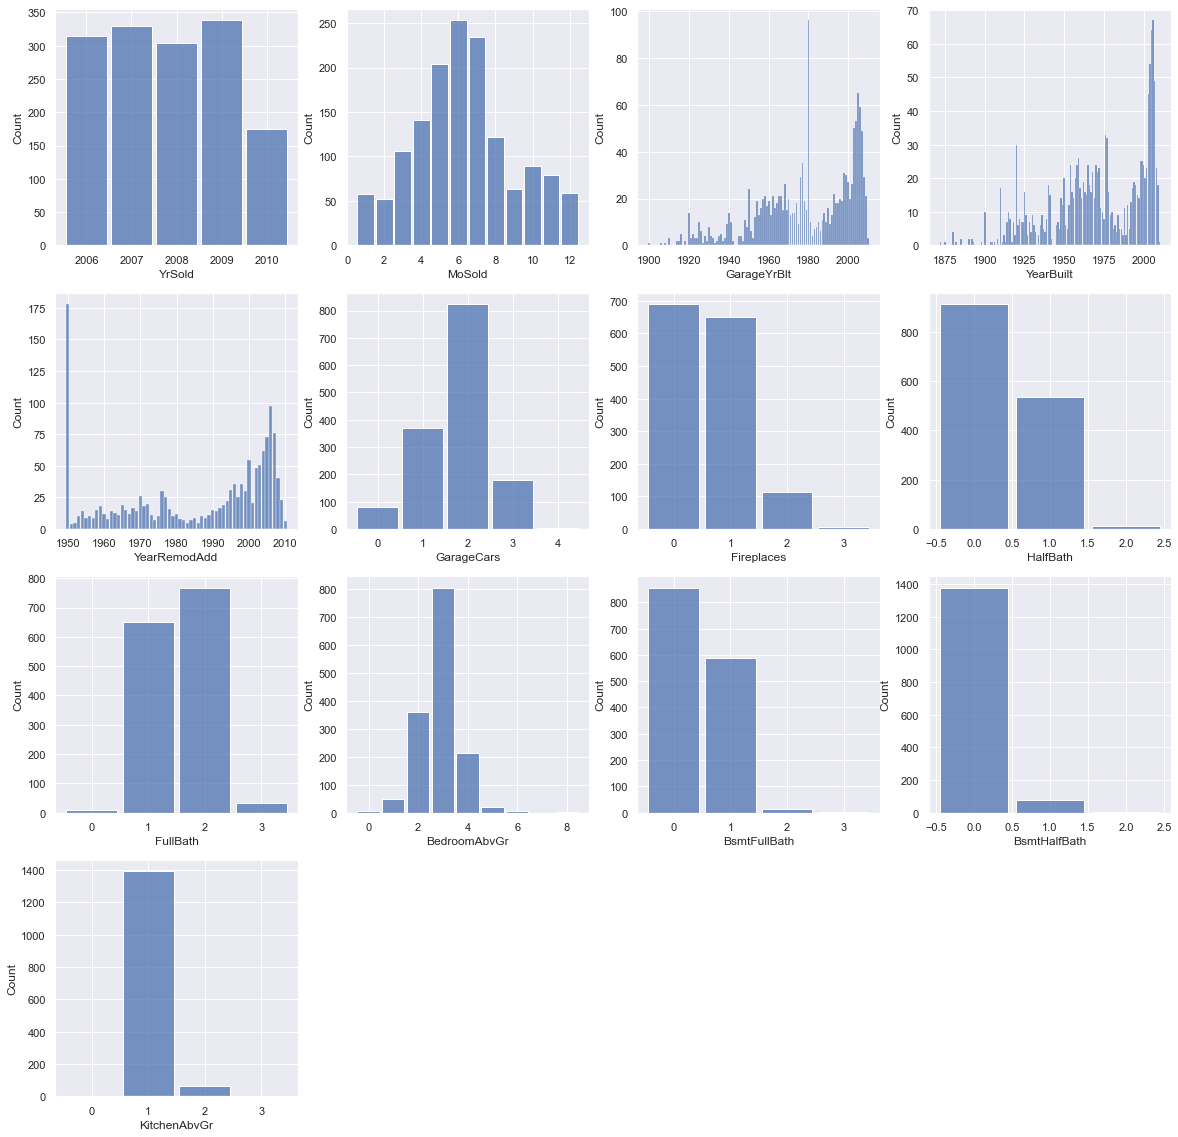

In [14]:
filt = (df_features["Data Subtype"] == 'Discrete')
cols = df_features.loc[filt,:].sort_values('Norm Entropy', ascending=False).index
fig, axs = util.plot_grid(df_clean, cols, plottype = 'histplot_discrete')

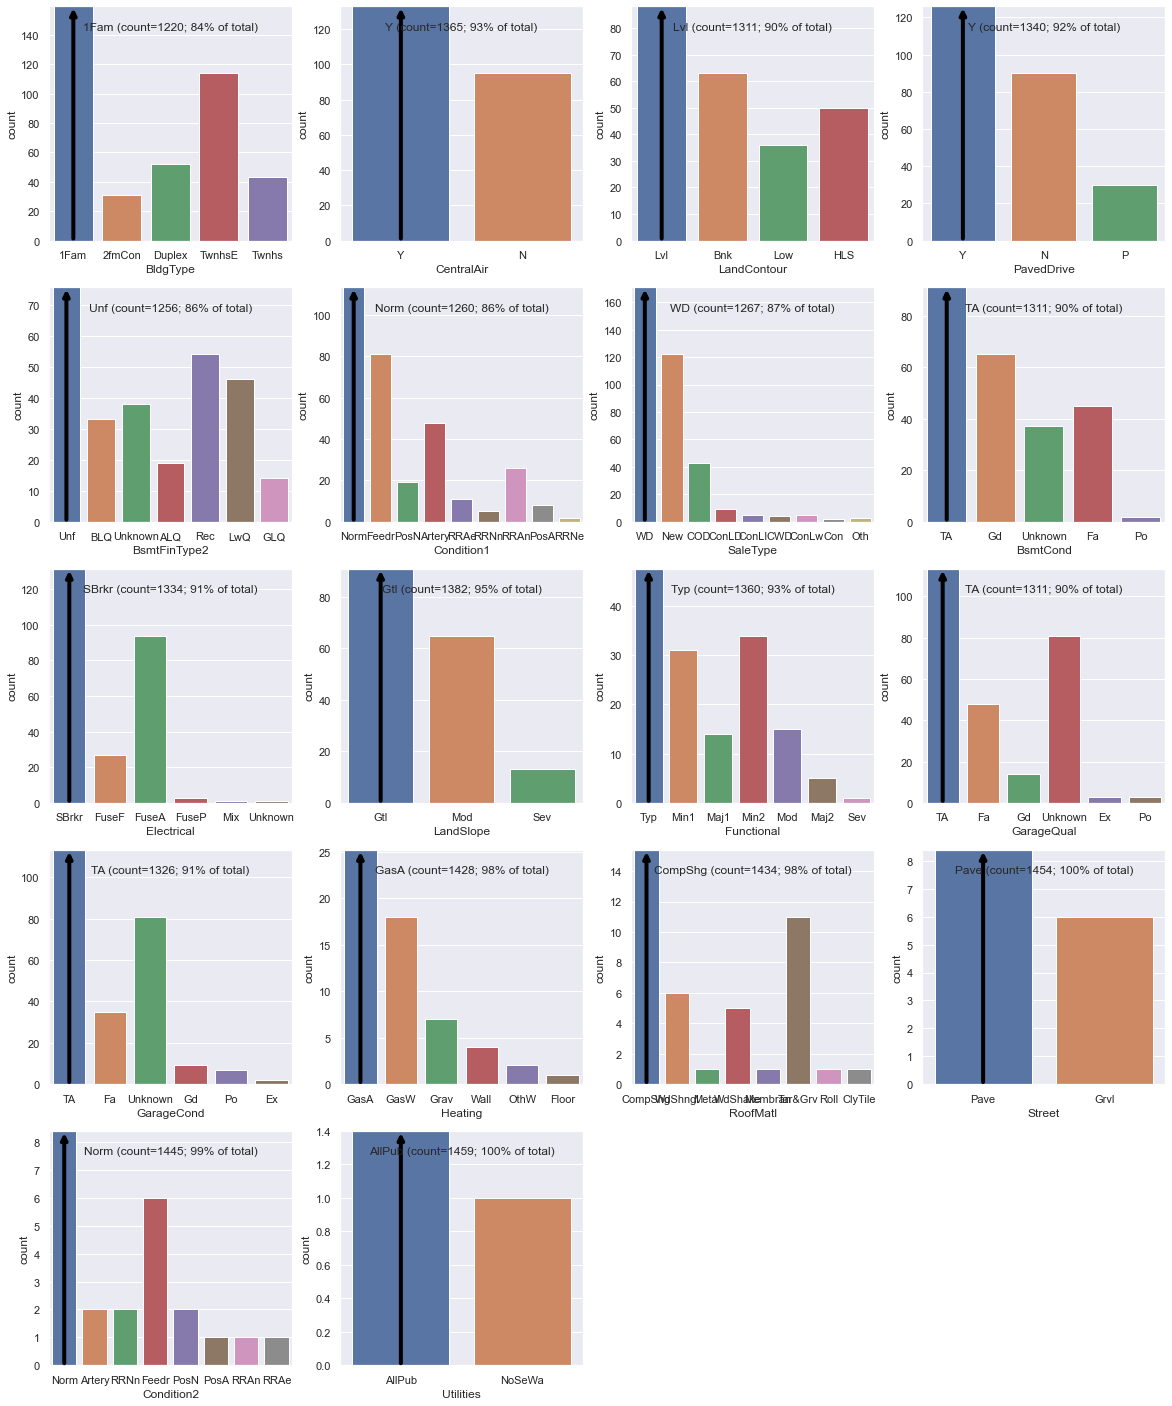

In [15]:
filt = (df_features["Data Type"] == 'Categorical') & (df_features["Mode Ratio"] > 10)
cols = df_features.loc[filt,:].sort_values('Norm Entropy', ascending=False).index
fig, axs = util.plot_grid(df_clean, cols, plottype='countplot_crop')

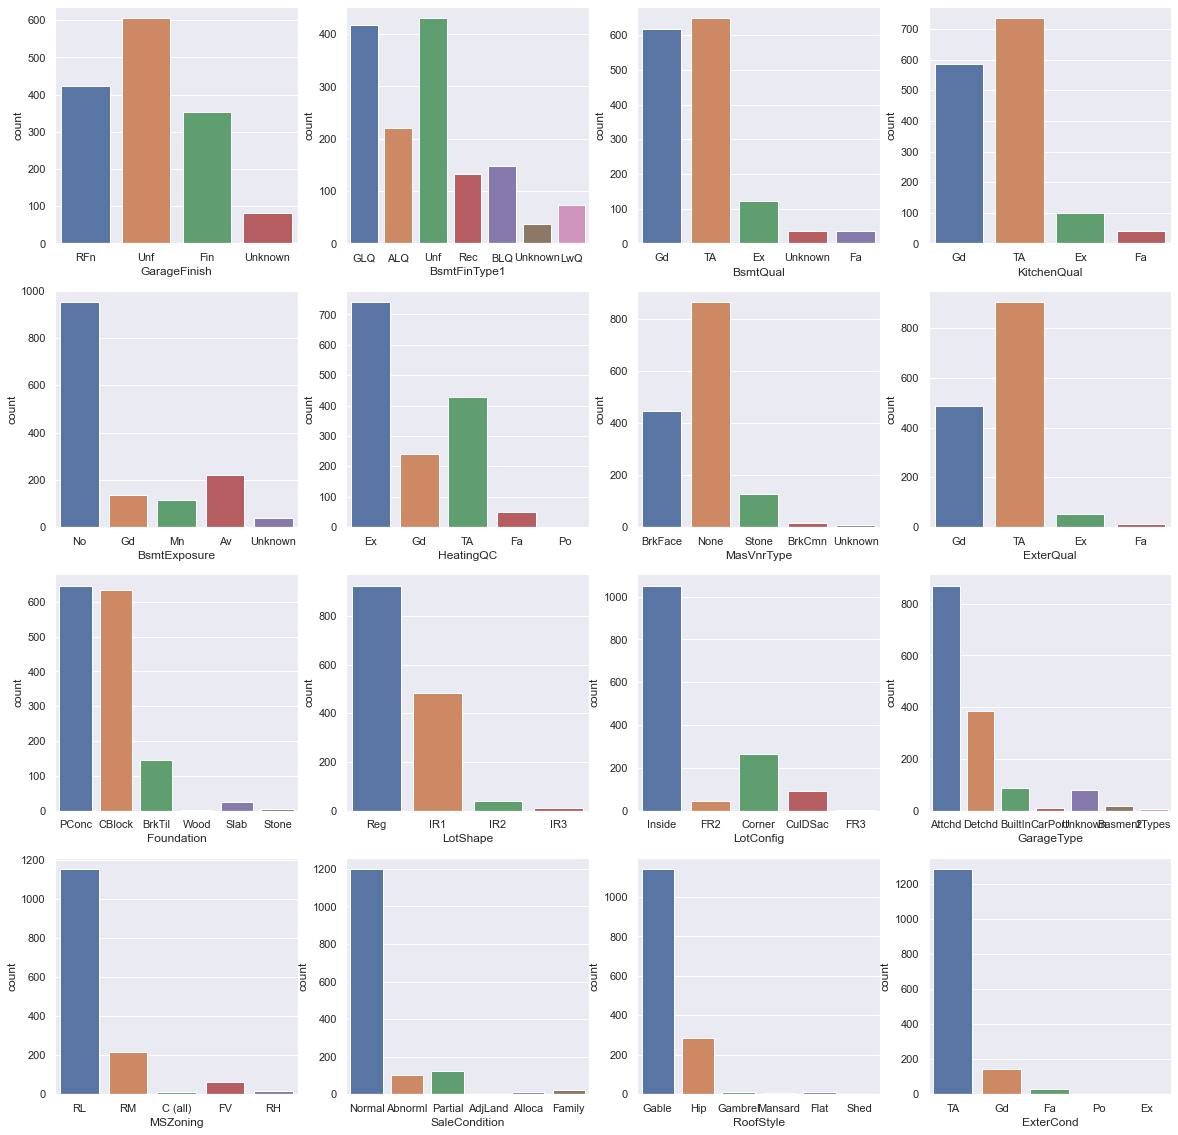

In [16]:
filt = ((df_features["Data Type"] == 'Categorical') 
     & (df_features["Mode Ratio"] <= 10)
     & (df_features["# Unique"] <= 6))
cols = df_features.loc[filt,:].sort_values('Norm Entropy', ascending=False).index
fig, axs = util.plot_grid(df_clean, cols, plottype='countplot_few')

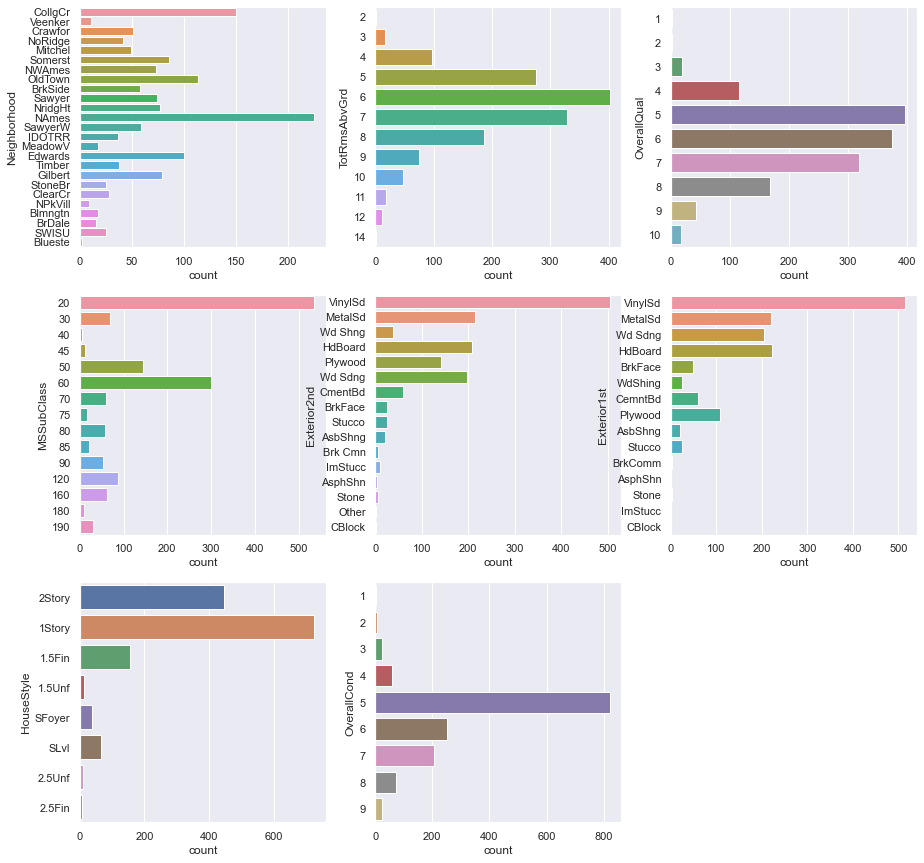

In [17]:
filt = ((df_features["Data Type"] == 'Categorical') 
     & (df_features["Mode Ratio"] <= 10)
     & (df_features["# Unique"] > 6))
cols = df_features.loc[filt,:].sort_values('Norm Entropy', ascending=False).index
fig, axs = util.plot_grid(df_clean, cols, plottype='countplot_many', ncols=3)

<a id="sec_selection"></a>
## Feature Selection
[top](#sec_toc)

In [18]:
## Square Footage formulas
# GrLivArea = 1stFlrSF + 2ndFlrSF + LowQualFinSF
# TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF
# LotArea
# MasVnrArea
# GarageArea
# WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch (Mutually exclusive?)
# PoolArea

In [19]:
def num_num_correlation_matrix(df, corr_mask=None, sig_thr=1):
    corr = df.rcorr(stars=False)
    
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Mask r values with significance above threshold
    for f1, f2 in itertools.combinations(corr.index, 2):
        row, col = corr.index.get_loc(f1), corr.index.get_loc(f2)
        if row == col:
            continue
        if row > col: # Focus on top triangle
            row, col = col, row
        if float(corr.iloc[row, col]) > sig_thr:
            mask[col, row] = 1
        
    # Mask r values for user specified feature
    if not corr_mask:
        corr_mask = []
    elif len(corr_mask) > 1 and type(corr_mask[0]) is not list:
        corr_mask = [corr_mask]
    for features in corr_mask:
        for f1, f2 in itertools.combinations(features, 2):
            row, col = corr.index.get_loc(f1), corr.index.get_loc(f2)
            if row < col: # Focus on bottom triangle
                row, col = col, row
            mask[row, col] = 1
        
    fig, ax = plt.subplots(1,figsize=(11,9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    corr[mask] = 0
    #display(corr)
    sns.heatmap(corr.astype('float')*100, 
                mask=mask, annot=True, fmt='.0f',
                cmap=cmap,
                center=0, #vmax=1, vmin=-1,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},)

corr_mask = [
    ['GarageCars', 'GarageArea'],
    ['YearBuilt','GarageYrBlt','YearRemodAdd']
]

def num_cat_corr(num_vals, cat_vals, method='R2'):
    pass

def num_cat_correlation_matrix(df, num_cols, cat_cols, method='R2'):
    n = len(df)
    corr = pd.DataFrame(np.zeros((len(num_cols),len(cat_cols))),
                        index=num_cols, columns=cat_cols)
    
    for num, cat in itertools.product(num_cols, cat_cols):
        corr.loc[num,cat] = num_cat_corr(df[num], df[cat], method)
        
    fig, ax = plt.subplots(1,figsize=(11,9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr*100, 
                annot=True, fmt='.0f',
                cmap=cmap,
                center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},)   
        

def cat_cat_correlation_matrix(df):
    pass

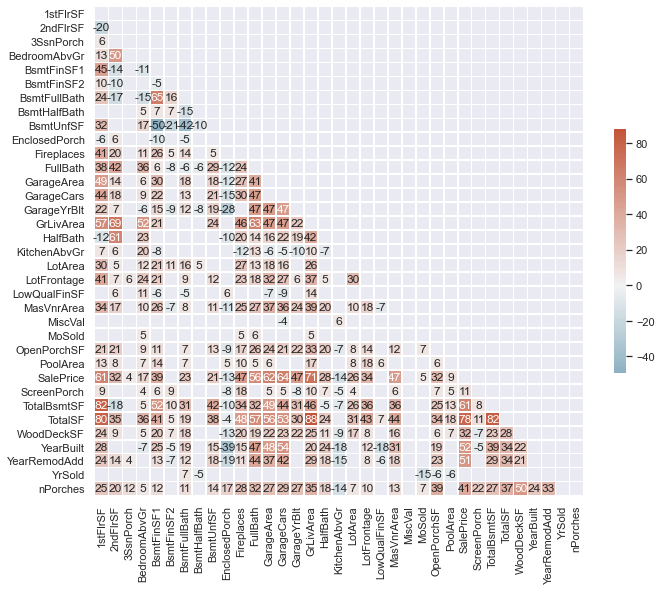

In [20]:
num_num_correlation_matrix(df_clean[num_cols], corr_mask, sig_thr = 0.1)

In [21]:
alpha = 0.05
target_corr = util.corr_to_target(df_clean, target_var, cat_cols)
target_corr = target_corr.sort_values(['Categorical','R2'], ascending=False)
ranked_f = target_corr.loc[target_corr['pval'] < alpha,:]
display(ranked_f)

,Categorical,R2,pval,MI
OverallQual,1,0.684181,6.442770e-18,0.572095
Neighborhood,1,0.545575,3.019500e-54,0.528478
ExterQual,1,0.477388,9.245777e-32,0.327577
BsmtQual,1,0.464994,3.507538e-58,0.327834
KitchenQual,1,0.456599,8.287137e-60,0.330621
GarageFinish,1,0.305874,4.657834e-89,0.264485
Foundation,1,0.256368,9.681547e-11,0.200665
GarageType,1,0.249204,4.477164e-24,0.210033
MSSubClass,1,0.246316,9.327621e-43,0.277309
BsmtFinType1,1,0.210810,1.257046e-55,0.153238


In [22]:
alpha = 0.1
df = df_clean
cat_features = cat_cols
sequential = True

df_tmp = df.copy()
df_tmp['Residual'] = df_tmp[target_var] - df_tmp[target_var].mean()
n_sig_corr = len(df_tmp.columns)
results = []
sel_features = ['TotalSF']
clf = LinearRegression()
enc = OneHotEncoder(drop='first', sparse=False)
print('Starting feature selection...', end='')
while n_sig_corr > 1:
    df_unused = df_tmp.drop(columns=sel_features+[target_var])
    target_corr = util.corr_to_target(df_unused, 'Residual', cat_features).sort_values('R2', ascending=False)
    ranked_f = target_corr.index[target_corr['pval'] < alpha]
    n_sig_corr = len(ranked_f)
    result = {}
    if n_sig_corr >= 1: 
        result['1st place'] = ranked_f[0]
        result['R2']         = target_corr.loc[ranked_f[0], 'R2']
        result['pval']      = target_corr.loc[ranked_f[0], 'pval']
        print(f'{ranked_f[0]} (R2={result["R2"]:.1%})...',end='')
    if n_sig_corr >= 2: 
        result['2nd place'] = ranked_f[1]
        result['2nd R2']     = target_corr.loc[ranked_f[1], 'R2']
        result['2nd pval']  = target_corr.loc[ranked_f[1], 'pval']
    if n_sig_corr >= 3: 
        result['3rd place'] = ranked_f[2]
        result['3rd R2']     = target_corr.loc[ranked_f[2], 'R2']
        result['3rd pval']  = target_corr.loc[ranked_f[2], 'pval']
    results.append(result)
    is_categorical = (ranked_f[0] in cat_features) or (df_tmp[ranked_f[0]].dtype == 'object')
    
    # Fit with best features
    sel_features.append(ranked_f[0])
    X = df_tmp[sel_features].copy()
    y = df_tmp[target_var]

    # One hot encoding of categorical features
    sel_cat_f = [f for f in sel_features if f in cat_features]
    enc.fit(X[sel_cat_f])
    onehot_features = enc.get_feature_names(sel_cat_f)
    X.loc[:,onehot_features] = enc.transform(X[sel_cat_f]).astype('int')
    X = X.drop(columns=sel_cat_f)
    
#     X, y = df_tmp[[ranked_f[0]]], df_tmp[target_var]
    
#     if is_categorical:
#         X = pd.DataFrame(enc.fit_transform(X).astype('int'))
#         X.columns = enc.get_feature_names([ranked_f[0]])

    y_pred = clf.fit(X, y).predict(X)
    df_tmp['Residual'] = y - y_pred

print()
    
df_sel_features = pd.DataFrame(results)
df_unsel_features = util.corr_to_target(df_tmp, target_var, cat_features).sort_values('R2', ascending=False)

display(df_sel_features)
display(df_unsel_features)

Starting feature selection...OverallQual (R2=68.4%)...Neighborhood (R2=12.7%)...MSSubClass (R2=4.4%)...BsmtExposure (R2=4.1%)...BsmtFinType1 (R2=2.2%)...SaleCondition (R2=2.1%)...GarageCars (R2=1.6%)...KitchenQual (R2=1.4%)...LotConfig (R2=1.3%)...GarageType (R2=1.1%)...ScreenPorch (R2=1.1%)...WoodDeckSF (R2=0.7%)...FullBath (R2=0.6%)...LotArea (R2=0.5%)...HalfBath (R2=0.5%)...CentralAir (R2=0.4%)...MSZoning (R2=0.4%)...BsmtFinType2 (R2=0.4%)...LotFrontage (R2=0.4%)...3SsnPorch (R2=0.3%)...2ndFlrSF (R2=0.3%)...Fireplaces (R2=0.4%)...Condition1 (R2=1.5%)...YearRemodAdd (R2=0.3%)...GarageCond (R2=0.2%)...BsmtFullBath (R2=0.2%)...MoSold (R2=0.2%)...


,1st place,R2,pval,2nd place,2nd R2,2nd pval,3rd place,3rd R2,3rd pval
0,OverallQual,0.684181,6.442770e-18,Neighborhood,0.545575,3.019500e-54,GrLivArea,0.502149,4.518034e-223
1,Neighborhood,0.126963,7.065756e-19,MSSubClass,0.079387,1.693828e-15,BsmtFinType1,0.060121,2.554188e-21
2,MSSubClass,0.044365,3.505090e-09,BsmtUnfSF,0.040477,8.471033e-15,BsmtExposure,0.038200,1.869625e-07
3,BsmtExposure,0.041108,4.394362e-09,BsmtUnfSF,0.035122,5.244809e-13,BsmtFinType1,0.034715,6.562584e-14
4,BsmtFinType1,0.022421,5.393074e-07,BsmtUnfSF,0.020874,2.941857e-08,SaleCondition,0.019310,3.184734e-02
5,SaleCondition,0.021083,4.189872e-02,GarageCars,0.018084,2.504808e-07,KitchenQual,0.016215,1.351743e-03
6,GarageCars,0.016228,1.043646e-06,KitchenQual,0.015268,9.613160e-04,GarageQual,0.013294,5.430769e-02
7,KitchenQual,0.014081,1.481691e-02,LotConfig,0.012321,1.869432e-02,GarageType,0.011707,4.227242e-02
8,LotConfig,0.013398,1.226784e-02,LotShape,0.011283,7.902742e-02,GarageType,0.010728,1.864249e-02
9,GarageType,0.010934,2.235102e-02,ScreenPorch,0.009480,1.946179e-04,2ndFlrSF,0.006879,1.514254e-03


,Categorical,R2,pval,MI
OverallQual,1,0.684181,6.442770e-18,0.577292
TotalSF,0,0.606777,8.320735e-298,0.661633
Neighborhood,1,0.545575,3.019500e-54,0.534396
GrLivArea,0,0.502149,4.518034e-223,0.483696
ExterQual,1,0.477388,9.245777e-32,0.326143
...,...,...,...,...
HeatingQC,1,NaN,NaN,0.164849
Electrical,1,NaN,NaN,0.052030
TotRmsAbvGrd,1,NaN,NaN,0.221314
Functional,1,NaN,NaN,0.006264


In [23]:
# Categorical Features
#kbest = 5
#selected_cat_cols = df_features.loc[cat_cols,:].sort_values('MI_C', ascending=False).index[:kbest].tolist()
selected_cat_cols = [f for f in sel_features if f in cat_cols]
print('Categorical Features:')
display(selected_cat_cols)

# Numerical Features
#kbest = 20
#selected_num_cols = df_features.loc[num_cols,:].sort_values('MI_R', ascending=False).index[:kbest+1].drop(target_var).tolist()
selected_num_cols = [f for f in sel_features if f in num_cols]
print('Numerical Features:')
display(selected_num_cols)

Categorical Features:


['OverallQual',
 'Neighborhood',
 'MSSubClass',
 'BsmtExposure',
 'BsmtFinType1',
 'SaleCondition',
 'KitchenQual',
 'LotConfig',
 'GarageType',
 'CentralAir',
 'MSZoning',
 'BsmtFinType2',
 'Condition1',
 'GarageCond']

Numerical Features:


['TotalSF',
 'GarageCars',
 'ScreenPorch',
 'WoodDeckSF',
 'FullBath',
 'LotArea',
 'HalfBath',
 'LotFrontage',
 '3SsnPorch',
 '2ndFlrSF',
 'Fireplaces',
 'YearRemodAdd',
 'BsmtFullBath',
 'MoSold']

<a id="sec_transformation"></a>
## Feature Transformation
[top](#sec_toc)

In [24]:
columns_to_keep = selected_num_cols + selected_cat_cols + ['SalePrice']
df_final = df_clean.loc[:,columns_to_keep]

encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(df_clean[selected_cat_cols])
onehot_features = encoder.get_feature_names(selected_cat_cols)
df_final.loc[:,onehot_features] = encoder.transform(df_final[selected_cat_cols])
df_final.loc[:,onehot_features] = df_final.astype({k:'int' for k in onehot_features})
df_final = df_final.drop(columns=selected_cat_cols)
print(columns_to_keep)

['TotalSF', 'GarageCars', 'ScreenPorch', 'WoodDeckSF', 'FullBath', 'LotArea', 'HalfBath', 'LotFrontage', '3SsnPorch', '2ndFlrSF', 'Fireplaces', 'YearRemodAdd', 'BsmtFullBath', 'MoSold', 'OverallQual', 'Neighborhood', 'MSSubClass', 'BsmtExposure', 'BsmtFinType1', 'SaleCondition', 'KitchenQual', 'LotConfig', 'GarageType', 'CentralAir', 'MSZoning', 'BsmtFinType2', 'Condition1', 'GarageCond', 'SalePrice']


<a id="sec_model"></a>
## Model Building
[top](#sec_toc)

In [25]:
clf = LinearRegression()
pt = PowerTransformer('box-cox', standardize=True)
#clf = TransformedTargetRegressor(regressor=clf, transformer=pt)

X_train = df_final.drop(columns=target_var)
y_train = df_final[target_var]

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
scores = np.sort(np.abs(scores))

n_features_used = len(columns_to_keep)-1
n_features = len(df_features.index)-1
print(f'Using {n_features_used} out of {n_features} features. Engineered into {len(X_train.columns)} features.')
print(f'Overall RMSE : ${round(scores.mean(),-3):n} +/- {round(scores.std(ddof=1),-3):n}')
print('\t', [f'${round(x,3):n}' for x in scores])

Using 28 out of 74 features. Engineered into 113 features.
Overall RMSE : $31000 +/- 6000
	 ['$23698.6', '$26711.9', '$31168.1', '$32792.8', '$40693.5']


### Log of progress
* 5-fold CV RMSE score
    * \$33000 +/- 5000 (Feb 24) - First time using numerical and categorical features
    * \$30000 +/- 6000 (Mar 6) - Used stepwise forward selection of features based on R2
    
    
* Potential improvements (see post-mortem below)
    * Study outliers and remove data that is likely corrupt
    * Study power transformations of target and features
    * Update stepwise feature selection to remove features that become insignificant
    * Study target encoding
    * Try other models : Ridge/ElasticNet regression -> Decision Tree -> AdaBoost & XGBoost
    
    

<a id="sec_post"></a>
## Post-mortem
[top](#sec_toc)

In [26]:
X_train = df_final.drop(columns=target_var)
y_train = df_final[target_var]

clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
residual = y_pred-y_train

df_pm = df_clean.copy()
df_pm['SalePrice Pred'] = y_pred
df_pm['Residual'] = residual

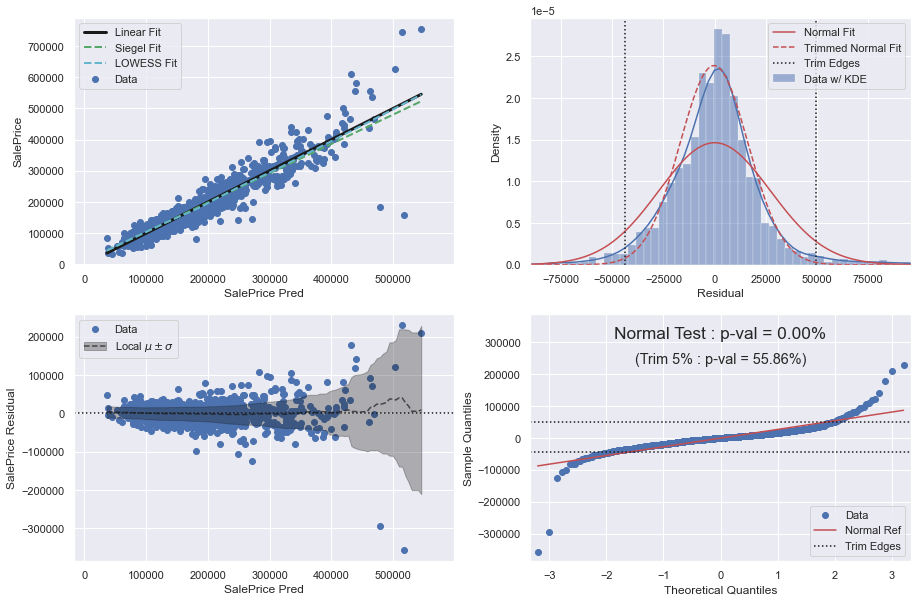

Correlation Measures:
	         Fit Slope = 1.00 +/- 0.01 (pval = 0.0%)
	       Pearson's r = 0.94 (pval = 0.0%; R2 = 0.88)
	      Spearman's r = 0.95 (pval = 0.0%)
	Mutual information = 1.272

Homoscedasticity Tests on Residuals: 
	 Breusch-Pagan p-value = 0.0%

Normality Tests on Residuals : 
	D'Agostino-Pearson p-value = 0.0%
	   Normal Kurtosis p-value = 0.0%
	       Normal Skew p-value = 0.0%

Autocorrelation Tests on Residuals : 
	Durbin-Watson = 1.9


In [27]:
num_num_corr_plots(df_pm, 'SalePrice Pred', 'SalePrice')

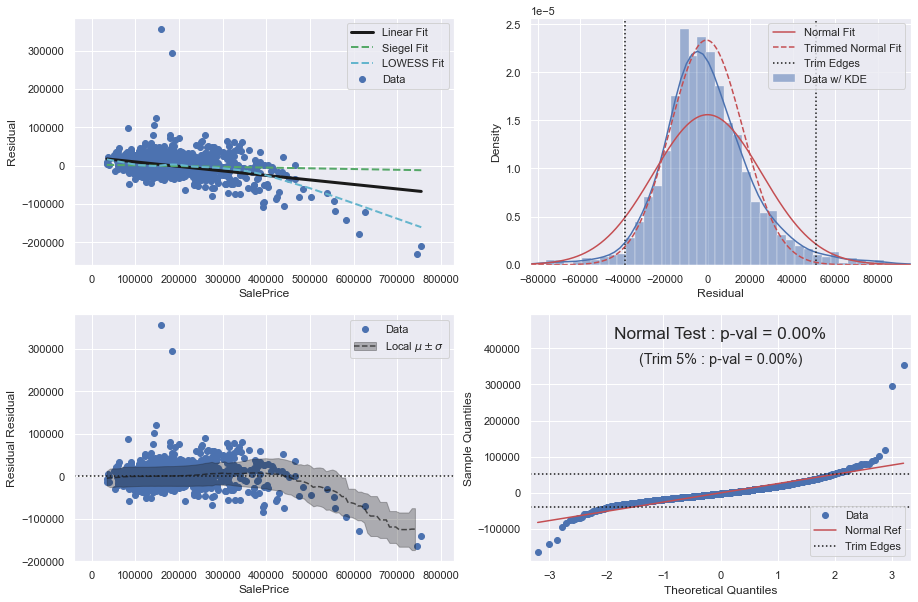

Correlation Measures:
	         Fit Slope = -0.12 +/- 0.01 (pval = 0.0%)
	       Pearson's r = -0.34 (pval = 0.0%; R2 = 0.12)
	      Spearman's r = -0.13 (pval = 0.0%)
	Mutual information = 0.106

Homoscedasticity Tests on Residuals: 
	 Breusch-Pagan p-value = 0.0%

Normality Tests on Residuals : 
	D'Agostino-Pearson p-value = 0.0%
	   Normal Kurtosis p-value = 0.0%
	       Normal Skew p-value = 0.0%

Autocorrelation Tests on Residuals : 
	Durbin-Watson = 1.9


In [28]:
num_num_corr_plots(df_pm, 'SalePrice', 'Residual')

<a id="sec_appendix"></a>
# Appendix
[top](#sec_toc)

## Compare Train and Test Inputs

In [30]:
# Check test data is similar to training data
result = defaultdict(dict)
for f in df_features.index.drop([target_var]):
    if df_features.loc[f,'Data Subtype'] != 'Continuous':
        unique_train = set(df_train[f].dropna().unique())
        unique_test  = set(df_test[f].dropna().unique())
        if unique_train - unique_test:
            result['Unique Train Values'][f] = unique_train - unique_test
        if unique_test  - unique_train: 
            result['Unique Test Values'][f] = unique_test - unique_train
    null_in_train = df_train[f].isnull().sum() > 0
    null_in_test  =  df_test[f].isnull().sum() > 0
    if null_in_train and not null_in_test:
        result['Unique Null'][f] = 'Train'
    elif null_in_test and not null_in_train:
        result['Unique Null'][f] = 'Test'
        
display(pd.DataFrame(result)[['Unique Train Values', 'Unique Test Values']].dropna(how='all'))
display(pd.DataFrame(result)[['Unique Null']].dropna(how='all'))

,Unique Train Values,Unique Test Values
MSSubClass,NaN,{150}
YearBuilt,"{1892, 1893, 1898, 1872, 1904, 1906, 1875, 190...","{1895, 1896, 1901, 1902, 1907, 1879}"
FullBath,NaN,{4}
TotRmsAbvGrd,"{2, 14}","{13, 15}"
Fireplaces,NaN,{4}
GarageYrBlt,"{1929.0, 1931.0, 1933.0, 1906.0, 1908.0, 1914.0}","{2207.0, 1895.0, 1896.0, 1943.0, 1917.0, 1919.0}"
GarageCars,NaN,{5.0}
Utilities,{NoSeWa},NaN
Exterior1st,"{Stone, ImStucc}",NaN
Exterior2nd,{Other},NaN


,Unique Null
GarageCars,Test
MSZoning,Test
Utilities,Test
Exterior1st,Test
Exterior2nd,Test
BsmtFinSF1,Test
BsmtFinSF2,Test
BsmtUnfSF,Test
TotalBsmtSF,Test
Electrical,Train


## Compare ANOVA $\eta^2$ and Linear Fit $R^2$ with OneHotEncoding

In [32]:
y = df_train['SalePrice'].values
x = df_train['OverallQual'].values
X = x.reshape(-1,1)

y_grp_mean = df_train.groupby('OverallQual')['SalePrice'].transform('mean')
sse = ((y - y_grp_mean)**2).sum()
sst = ((y - y.mean())**2).sum() 
R2_n2 = 1 - sse/sst
R2_n2_pg = pg.anova(df_train, dv='SalePrice', between='OverallQual', effsize='n2')['n2'][0]

X_enc = OneHotEncoder(drop='first', sparse=False).fit_transform(X).astype(int)
y_pred = sm.OLS(y, X_enc).fit().predict(X_enc)
sse = ((y - y_pred)**2).sum()
sst = ((y - y.mean())**2).sum()
R2_lin = 1 - sse/sst

print(f'R2 from linear fit    : {R2_lin}')
print(f'R2 from ANOVA n2      : {R2_n2}')
print(f'R2 from ANOVA n2 (pg) : {R2_n2_pg}')

R2 from linear fit    : 0.6836350125880637
R2 from ANOVA n2      : 0.6841812868534439
R2 from ANOVA n2 (pg) : 0.6841812868534438


## Find optimal target encoding

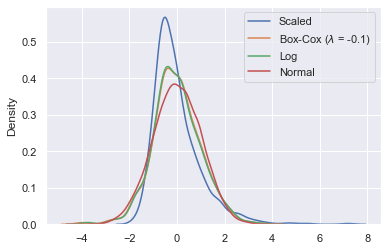

In [33]:
pt = PowerTransformer()
y = df_clean[[target_var]]
y2d = y.values
y1d = y2d[:,0]

y1 = (y1d - y1d.mean())/y1d.std(ddof=1)
pt.fit(y)
y2 = pt.transform(y2d)[:,0] 
y3 = np.log(y1d)
y3 = (y3-y3.mean())/y3.std(ddof=1)
y_norm = stats.norm.rvs(size=10000)

sns.kdeplot(y1.tolist(), label='Scaled')
sns.kdeplot(y2.tolist(), label=f'Box-Cox ($\lambda$ = {pt.lambdas_[0]:.1f})')
sns.kdeplot(y3.tolist(), label=f'Log')
sns.kdeplot(y_norm, label='Normal')
plt.legend()

df = df_clean
group = 'OverallQual'
target = target_var

# Mean/Median

# Additive smoothing (ce.target_encoder)

# Polynomial fit

def target_encoding(df, group, target):
    pass
target_encoding(df, 'OverallQual', target_var)

## Feature engineering motivation

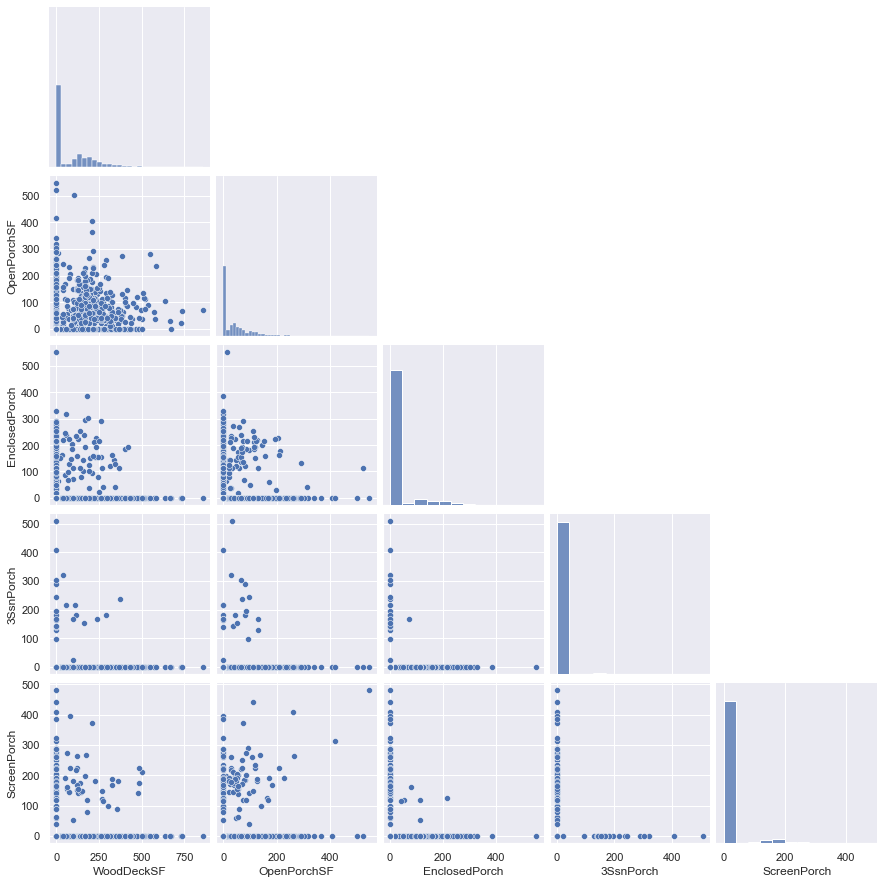

In [34]:
corr_check = ['WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
#corr_check = ['GarageCars','GarageArea']
#corr_check = ['YearBuilt','GarageYrBlt','YearRemodAdd']
#corr_check = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath']
sns.pairplot(df_train[corr_check], corner=True, dropna=True)

## Check if all selected features are necessary

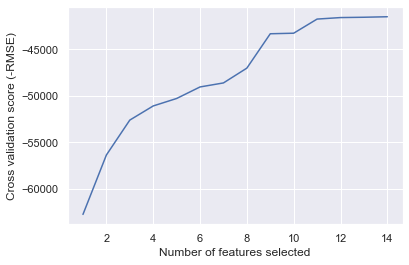

Optimal number of features : 14
Feature ranking:
	 0 - Rank  1) TotalSF
	 1 - Rank  1) GarageCars
	 2 - Rank  1) ScreenPorch
	 3 - Rank  1) WoodDeckSF
	 4 - Rank  1) FullBath
	 5 - Rank  1) LotArea
	 6 - Rank  1) HalfBath
	 7 - Rank  1) LotFrontage
	 8 - Rank  1) 3SsnPorch
	 9 - Rank  1) 2ndFlrSF
	10 - Rank  1) Fireplaces
	11 - Rank  1) YearRemodAdd
	12 - Rank  1) BsmtFullBath
	13 - Rank  1) MoSold


In [35]:
X_train = df_clean[selected_num_cols]
y_train = df_clean['SalePrice']

estimator = LinearRegression(normalize=True)
# selector = SequentialFeatureSelection(estimator, 
#                                       n_features_to_select=0.99, 
#                                       scoring='neg_root_mean_squared_error')
selector = RFECV(estimator,
                 scoring='neg_root_mean_squared_error')

selector.fit(X_train, y_train)

#df_train = selector.transform(df_train)

# If RFECV is used
n_scores = len(selector.grid_scores_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (-RMSE)")
x_range = np.arange(len(selector.grid_scores_)) + 1
plt.plot(x_range, selector.grid_scores_)
plt.show()
print("Optimal number of features : %d" % selector.n_features_)

print("Feature ranking:")
for i, rank in sorted(enumerate(selector.ranking_), key=lambda x : x[1]):
    feature_name = X_train.iloc[:,i].name
    print(f'\t{i:2} - Rank {rank:2}) {feature_name}')

## Discretizing continuous distribution to assess homoscedasticity

,Strategy,nBins,W,pval,equal_var
9,quantile,20,11.055898,1.211072e-31,False
11,quantile,10,18.076088,1.001817e-28,False
4,kmeans,5,29.789488,7.566709e-24,False
8,quantile,5,26.444307,3.379969e-21,False
10,quantile,50,4.420853,6.002037e-21,False
0,uniform,5,20.834671,1.021022e-16,False
3,uniform,10,10.816809,2.076672e-16,False
7,kmeans,10,10.399449,1.066128e-15,False
1,uniform,20,5.997999,1.344598e-13,False
5,kmeans,20,5.399658,6.108055e-13,False


quantile 10


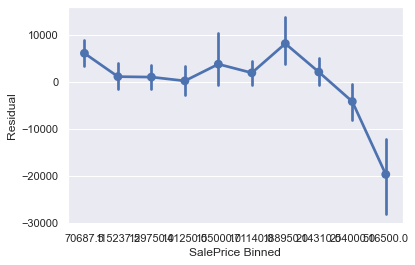

In [38]:
bin_strategy = ['uniform','kmeans','quantile']
n_bins = [5, 20, 50, 10]
results = []

for s in bin_strategy:
    for n in n_bins:
        est = KBinsDiscretizer(n_bins=n, encode='ordinal', strategy=s)
        target_binned = est.inverse_transform(est.fit_transform(X=df_pm[target_var].to_frame())).flatten()
        df_pm['SalePrice Binned'] = target_binned
        result = pg.homoscedasticity(data=df_pm, dv='Residual', group='SalePrice Binned')
        results.append([s, n] + result.values.tolist()[0])

results = pd.DataFrame(results, columns=['Strategy', 'nBins', 'W', 'pval', 'equal_var'])
display(results.sort_values('pval'))

print(s, n)
sns.pointplot(data=df_pm, x='SalePrice Binned', y='Residual')